# Цены закрытия акций фармацевтических компаний до и после начала эпидемии

In [4]:
import pandas_datareader.data as web
import pandas as pd
import matplotlib.pyplot as plt
import datetime

## Данные о случаях заражения

In [12]:
covid = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv')[['date', 'cases']]
covid['date'] = pd.to_datetime(covid['date']).dt.date
covid = covid.set_index('date')

Text(0.5, 1.0, 'Количество случаев заражения COVID-19 в США, млн')

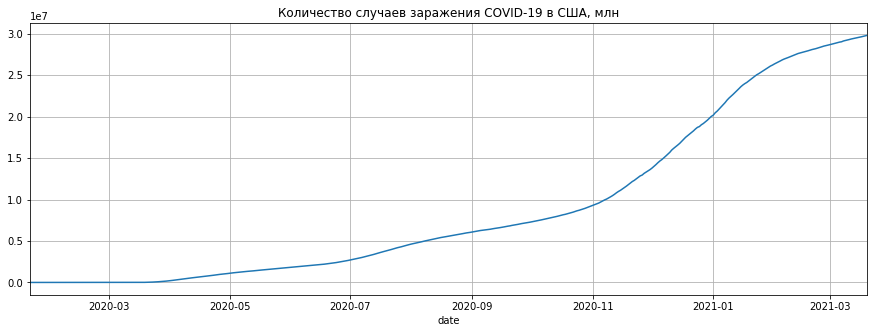

In [13]:
covid['cases'].plot(figsize = (15,5), grid = True)
plt.title('Количество случаев заражения COVID-19 в США, млн')

Будем считать, что после 1 мая 2020 г. число случаев начало существенно увеличиваться. Примем эту дату за начало эпидемии.

## Получение цен акций трёх основных производителей вакцин

Основные производители вакцин: Pfizer (NYSE: PFE), Moderna (NASDAQ: MRNA), AstraZeneca (LON: AZN)

In [14]:
start_date = datetime.datetime(2019, 1, 1) #временной интервал исследования
end_date = datetime.datetime(2021, 1, 1)

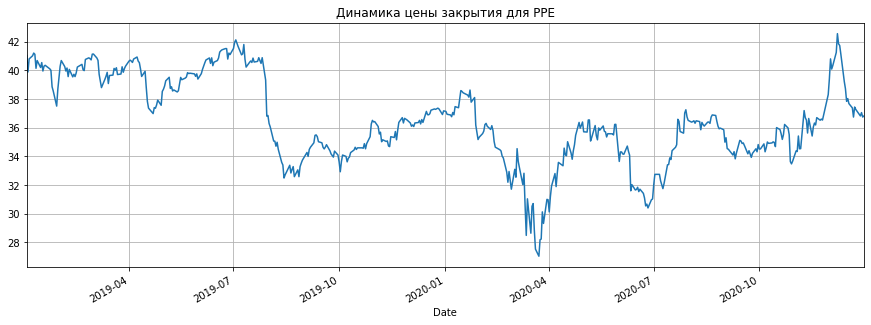

In [15]:
pfe = web.DataReader('PFE', start = start_date, end = end_date, data_source = 'yahoo')  #Pfizer

pfe['Close'].plot(figsize=(15, 5), grid = True)
plt.title('Динамика цены закрытия для {}'.format('PPE'));

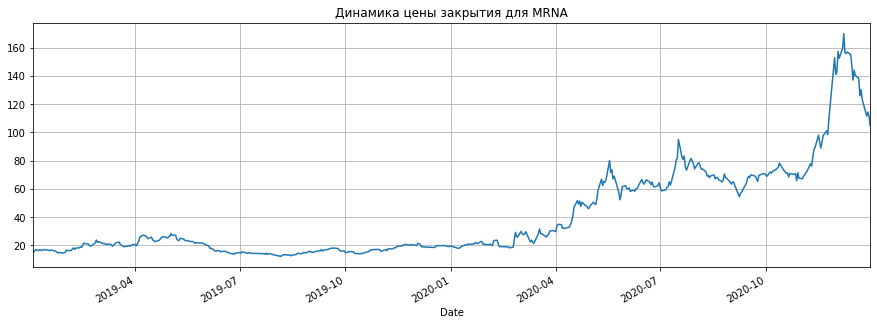

In [16]:
mrna = web.DataReader('MRNA', start = start_date, end = end_date, data_source = 'yahoo')  #Moderna

mrna['Close'].plot(figsize=(15, 5), grid = True)
plt.title('Динамика цены закрытия для {}'.format('MRNA'));

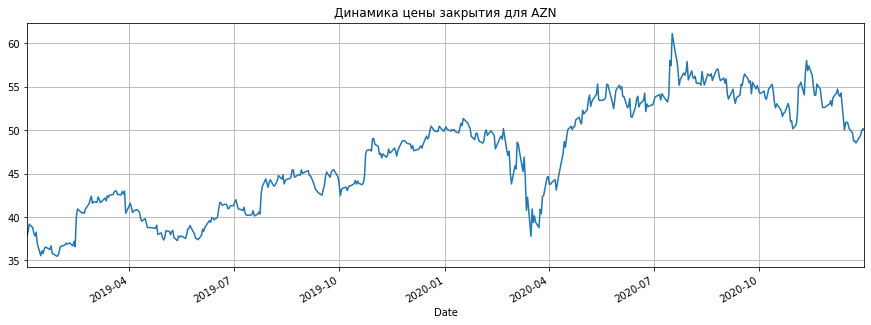

In [17]:
azn = web.DataReader('AZN', start = start_date, end = end_date, data_source = 'yahoo')  #AstraZeneca

azn['Close'].plot(figsize=(15, 5), grid = True)
plt.title('Динамика цены закрытия для {}'.format('AZN'));

In [19]:
pharma_tickers = ['MRNA', 'AZN', 'PFE']

pharma = pd.DataFrame()
for ticker in pharma_tickers:
    current = web.DataReader(ticker, start = start_date, end = end_date, data_source = 'yahoo')[['Close']]
    current['Компания'] = ticker
    pharma = pharma.append(current)
    
pharma = pharma.reset_index()
pharma['Date'] = pharma['Date'].dt.date

## Анализ динамики цен

In [27]:
report = pharma.pivot_table(index = 'Date', columns = 'Компания', values = 'Close', aggfunc = 'max') #Сводная таблица с ценой закрытия по дням
report.head()

Компания,AZN,MRNA,PFE
Date,,,
2019-01-02,37.799999,15.330000,41.034157
2019-01-03,38.330002,15.500000,39.886147
2019-01-04,39.180000,16.959999,40.796963
2019-01-07,38.779999,16.270000,41.015179
2019-01-08,38.130001,16.950001,41.204933


In [28]:
report = report.join(covid[['cases']]).fillna(0) #добавим данные о случаях заражения

Рассчитаем корреляцию между ценами и количеством заражений:

In [31]:
report.corr()[['cases']].rename(columns = {'cases': 'Степень корреляции'}).sort_values(by = 'Степень корреляции', ascending = False)

,Степень корреляции
cases,1.000000
MRNA,0.911892
AZN,0.556634
PFE,-0.019219


Из всех компаний некоторую связь с числом заражений показывает только цена MRNA (91%), для остальных компаний очевидной зависимости нет.

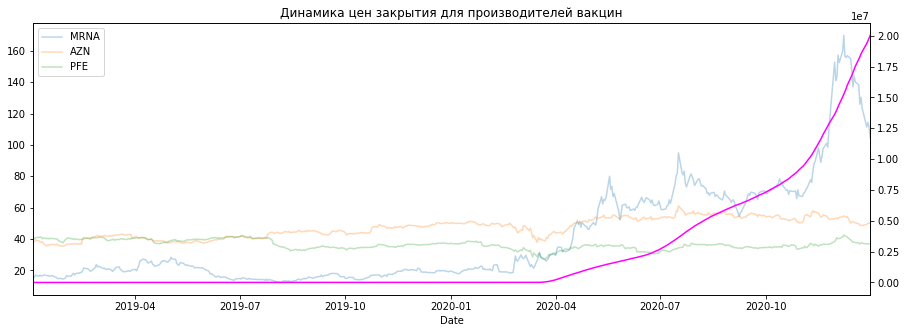

In [33]:
ax = report[pharma_tickers].plot(figsize = (15,5), alpha = 0.3)
report['cases'].plot(ax = ax.twinx(), color = 'magenta')
plt.title('Динамика цен закрытия для производителей вакцин');

График подтверждает выводы, сделанные на основе коэффициента корреляции. Только акции Moderna коррелировали с увеличением числа случаев заражения.

## Анализ распределений цен до и после начала эпидемии

In [35]:
covid_start = datetime.datetime(2020, 5, 1).date()
report['before_after'] = 'До эпидемии'
report.loc[report.index > covid_start, 'before_after'] = 'После начала эпидемии'

Построим гистограмму распределения цен для компаний:

Средняя цена до эпидемии составляла $36.94
Средняя цена после начала эпидемии составляла $35.40


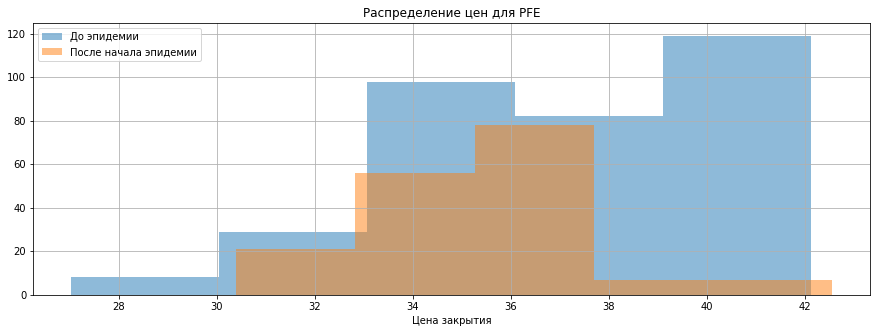

In [39]:
def compare_prices(data, ticker):
    plt.figure(figsize = (15, 5))
    for ba in data['before_after'].unique(): #переберем периоды времени - до и после начала эпидемии
        data.query('before_after == @ba')[ticker].hist(bins = 5, alpha = 0.5, label = ba) #построим гистограмму для каждого периода
        print('Средняя цена {} составляла ${:.2f}'.format(ba.lower(), data.query('before_after == @ba')[ticker].mean())) #выведем средние цены для двух периодов
    plt.legend()
    plt.xlabel('Цена закрытия')
    plt.title('Распределение цен для {}'.format(ticker));
    
compare_prices(report, 'PFE')

Заметно, что средняя цена Pfizer после начала эпидемии снизилась с 37 до 35 долларов.

Средняя цена до эпидемии составляла $20.53
Средняя цена после начала эпидемии составляла $79.76


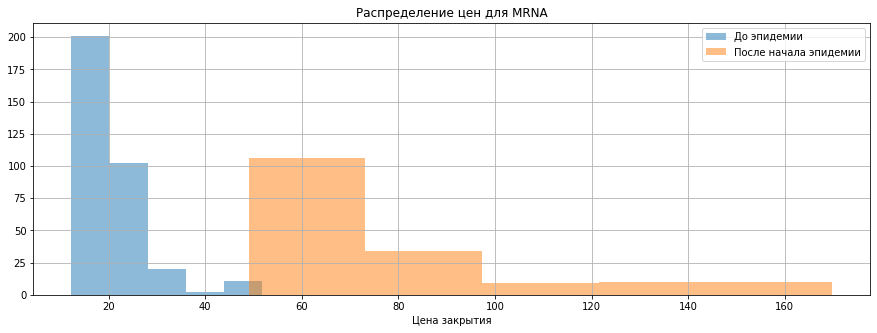

In [40]:
compare_prices(report, 'MRNA')

Акции Moderna существенно выросли.

Средняя цена до эпидемии составляла $43.57
Средняя цена после начала эпидемии составляла $54.09


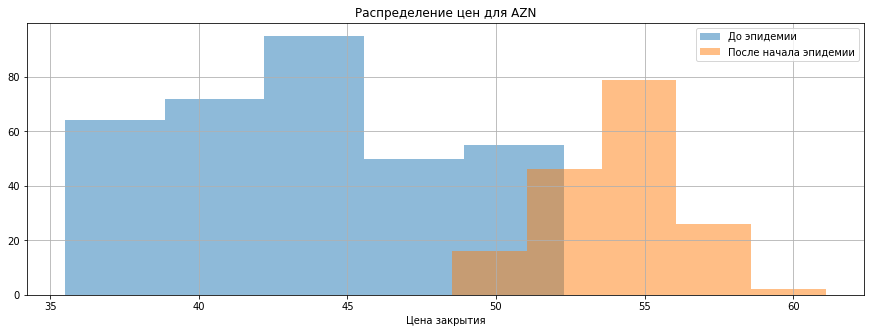

In [41]:
compare_prices(report, 'AZN')

Акции AstraZeneca увеличились, но не так значительно, как акции Moderna.

Почему существенное увеличение претерпела только цена акций компании Moderna? Одна из причин в том, что компания Moderna до эпидемии была молодой компанией, которая не успела выпустить ни одного коммерческого лекарства, но очень удачно включилась в вакцинную гонку. Её акции мало стоили до начала эпидемии - это сделало их привлекательными для покупки, а потом начался бум. Кроме того, продажа вакцин значительно менее прибыльна, чем производство и продажа лекарств, отпускаемых по рецепту, поэтому крупные компании, такие как Pfizer, едва ли получат большую прибыль. В результате, сильно выстрелила только Moderna. 